In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import cv2

import glob
from tqdm import tqdm

In [3]:
df = pd.read_csv('labels_highres.csv')
df

,id,angle
0,Image-0--50.png,2
1,Image-0--191.png,-21
2,Image-0-510.png,1
3,Image-0-92.png,0
4,Image-0-23.png,-5
...,...,...
105,Image-9--15.png,-7
106,Image-9--126.png,-7
107,Image-9-07.png,-2
108,Image-9-38.png,-1


In [4]:
scaler = StandardScaler()
df['angle_scaled'] = scaler.fit_transform(df['angle'].values.reshape(len(df), 1))
df

,id,angle,angle_scaled
0,Image-0--50.png,2,0.263606
1,Image-0--191.png,-21,-1.794799
2,Image-0-510.png,1,0.174110
3,Image-0-92.png,0,0.084614
4,Image-0-23.png,-5,-0.362865
...,...,...,...
105,Image-9--15.png,-7,-0.541857
106,Image-9--126.png,-7,-0.541857
107,Image-9-07.png,-2,-0.094377
108,Image-9-38.png,-1,-0.004882


In [5]:
# loading training images
train_img = []
for img_name in df['id']:
    # defining the image path
    image_path = 'dataset/' + str(img_name)
    # reading the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # normalizing the pixel values
    img /= 255.0   
    # appending the image into the list
    train_img.append(img)
# converting the list to numpy array
X = np.array(train_img)
# defining the target
y = df['angle_scaled'].values
X.shape

AttributeError: 'NoneType' object has no attribute 'astype'

In [5]:
X = df['id'].values
# defining the target
y = df['angle_scaled'].values

In [6]:
X[0]

'Image-0--50.png'

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

In [8]:
y

array([ 0.26360602, -1.794799  ,  0.17411015,  0.08461428, -0.36286507,
       -0.00488159,  0.53209363,  0.53209363, -0.45236094, -0.45236094,
        1.5165482 ,  0.17411015,  1.06906885, -0.63135268, -1.34731965,
       -0.81034443, -1.34731965,  0.6215895 ,  1.06906885, -0.8998403 ,
        0.89007711,  0.17411015, -0.63135268, -1.794799  , -1.34731965,
        0.6215895 , -1.794799  , -0.63135268, -1.16832791,  1.69553994,
       -0.72084856,  1.5165482 , -0.00488159,  0.26360602,  1.69553994,
        0.26360602,  0.44259776,  0.17411015, -0.36286507,  0.6215895 ,
       -0.98933617,  1.15856472, -1.43681552, -1.25782378,  2.05352342,
        0.89007711, -0.98933617, -0.18387333, -1.25782378,  1.60604407,
        0.53209363,  0.53209363, -0.00488159, -0.36286507, -0.54185681,
        2.50100277, -1.07883204,  1.5165482 , -1.16832791,  1.06906885,
       -1.61580726, -1.88429487, -0.54185681, -0.18387333, -0.36286507,
        1.69553994,  0.6215895 ,  1.5165482 , -0.72084856,  0.44

In [9]:
class SkewDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # defining the image path
        image_path = 'dataset_highres/' + self.images[idx]
        # reading the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        label = torch.from_numpy(np.array([self.labels[idx]])).float()
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True)

In [11]:
train_dataset = SkewDataset(X_train, y_train, transform=transform)
valid_dataset = SkewDataset(X_val, y_val, transform=transform)
test_dataset = SkewDataset(X_test, y_test, transform=transform)

In [12]:
train_dataset[0][0].size()

torch.Size([1, 1024, 1024])

In [13]:
train_loader = DataLoader(
    train_dataset, batch_size=8, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=8, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=8, shuffle=False
)

In [15]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [14]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

IndexError: index 8 is out of bounds for axis 0 with size 8

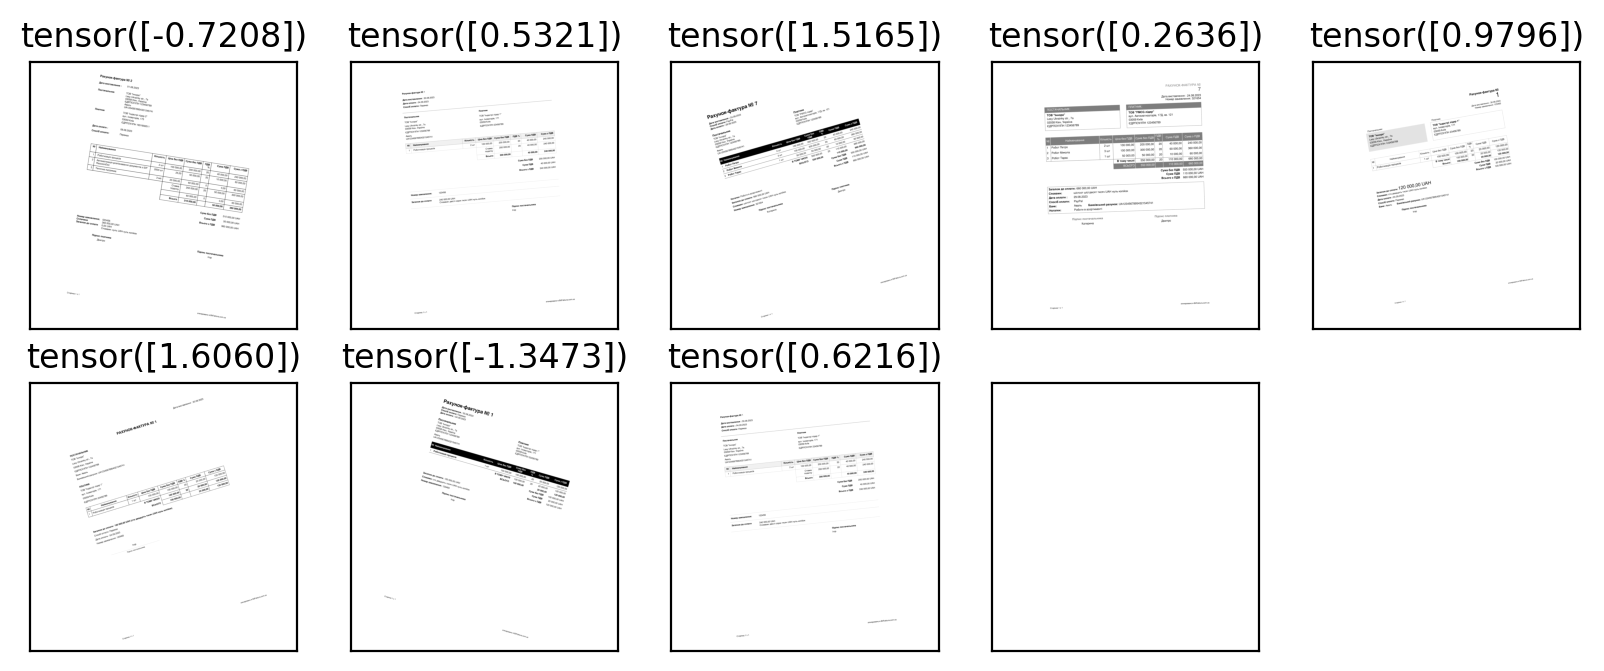

In [15]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 8))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx,0] * 255, cmap='gray')
    ax.set_title(labels[idx])

Feature batch shape: torch.Size([4, 1, 1024, 1024])
Labels batch shape: torch.Size([4, 1])


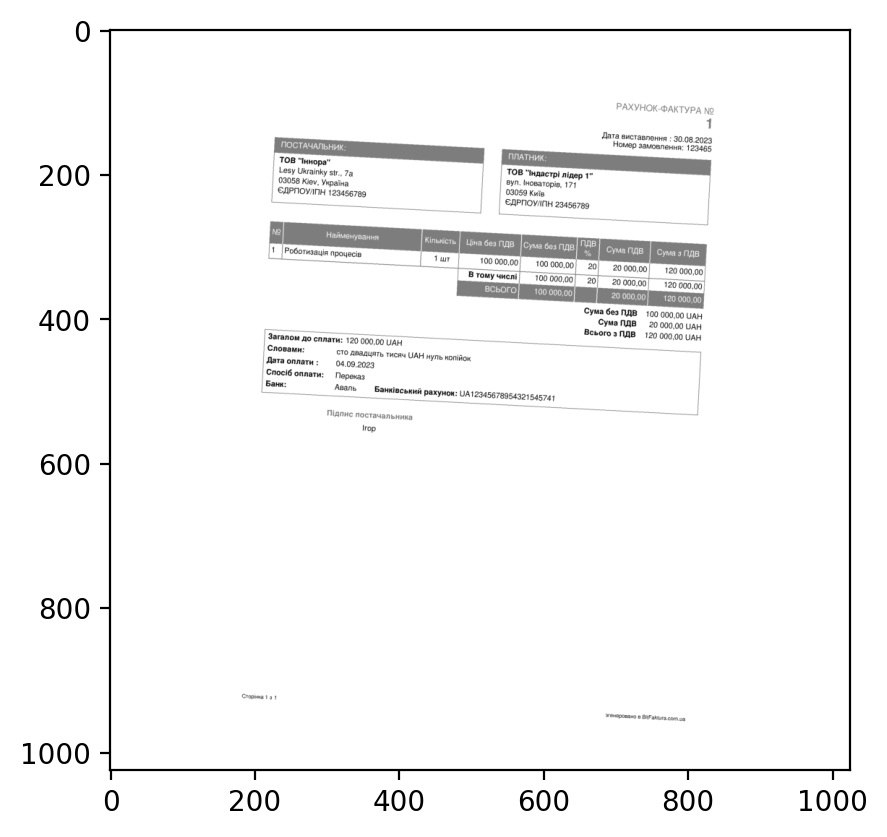

Label: tensor([-0.1839])


In [18]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4)
        )
        self.flat = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*32*32, 256),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        # TODO add sequence of convolutional and max pooling layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flat(x)
        return x

model = Net()
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 16801025


In [50]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train_on_gpu = torch.cuda.is_available()

In [51]:
# number of epochs to train the model
n_epochs = 50
model.cuda()
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.391483 	Validation Loss: 0.750267
Validation loss decreased (inf --> 0.750267).  Saving model ...
Epoch: 2 	Training Loss: 0.431545 	Validation Loss: 0.268192
Validation loss decreased (0.750267 --> 0.268192).  Saving model ...
Epoch: 3 	Training Loss: 0.166096 	Validation Loss: 0.254295
Validation loss decreased (0.268192 --> 0.254295).  Saving model ...
Epoch: 4 	Training Loss: 0.101173 	Validation Loss: 0.179176
Validation loss decreased (0.254295 --> 0.179176).  Saving model ...
Epoch: 5 	Training Loss: 0.097436 	Validation Loss: 0.111604
Validation loss decreased (0.179176 --> 0.111604).  Saving model ...
Epoch: 6 	Training Loss: 0.089204 	Validation Loss: 0.232395
Epoch: 7 	Training Loss: 0.067293 	Validation Loss: 0.133519
Epoch: 8 	Training Loss: 0.076857 	Validation Loss: 0.153086
Epoch: 9 	Training Loss: 0.053086 	Validation Loss: 0.099129
Validation loss decreased (0.111604 --> 0.099129).  Saving model ...
Epoch: 10 	Training Loss: 0.028456 	Valida

In [69]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

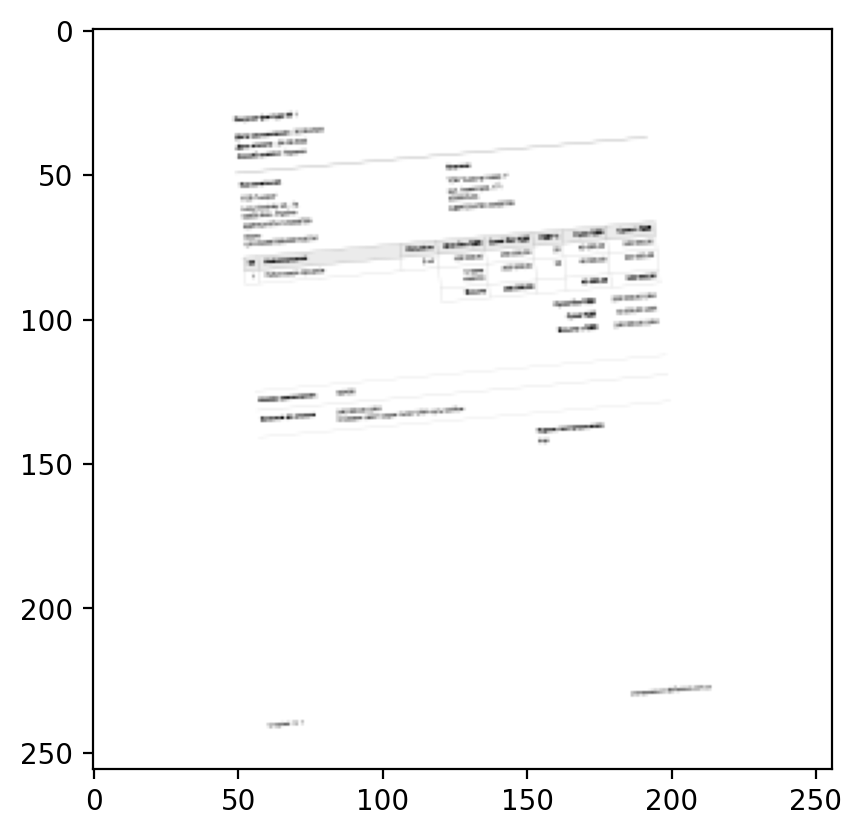

Angle: 38.8923225402832


In [157]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

model = Net()
model.load_state_dict(torch.load('model_cifar.pt'))
model.eval()
# get sample outputs
output = model(images)
output = output.cpu().detach().numpy()
rt_angle = scaler.inverse_transform(output)[1][0]
# Display image and label.
img = images[1].squeeze()
img = img.cpu().detach().numpy()
label = labels[1]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Angle: {rt_angle}")

In [2]:
import PIL
from PIL import Image, ImageOps

In [87]:
img

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [67]:
img = img * 255
img = Image.fromarray(img)
img = img.rotate(-rt_angle, PIL.Image.NEAREST, expand = 1, fillcolor = 'white')
plt.imshow(img, cmap="gray")
plt.show()
print(f"Angle: {rt_angle}")

AttributeError: 'Tensor' object has no attribute '__array_interface__'

NameError: name 'transform' is not defined

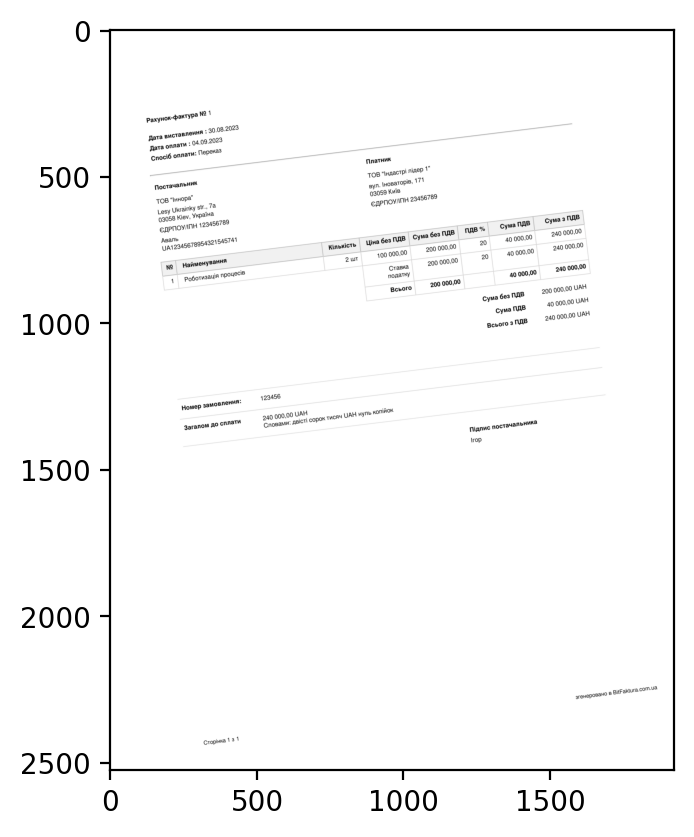

In [5]:
model = Net()
model.load_state_dict(torch.load('model_cifar.pt'))
model.eval()

imge = Image.open('invoices_rotated/0.png')
plt.imshow(imge)
imge = ImageOps.grayscale(imge)
imge = cv2.resize(np.array(imge), (1024, 1024), interpolation = cv2.INTER_AREA)
imge = transform(imge)


output = model(torch.unsqueeze(imge, dim=0))
output = output.cpu().detach().numpy()

rt_angle = scaler.inverse_transform(output)[0][0]
# Display image and label.

print(f"Angle: {rt_angle}")

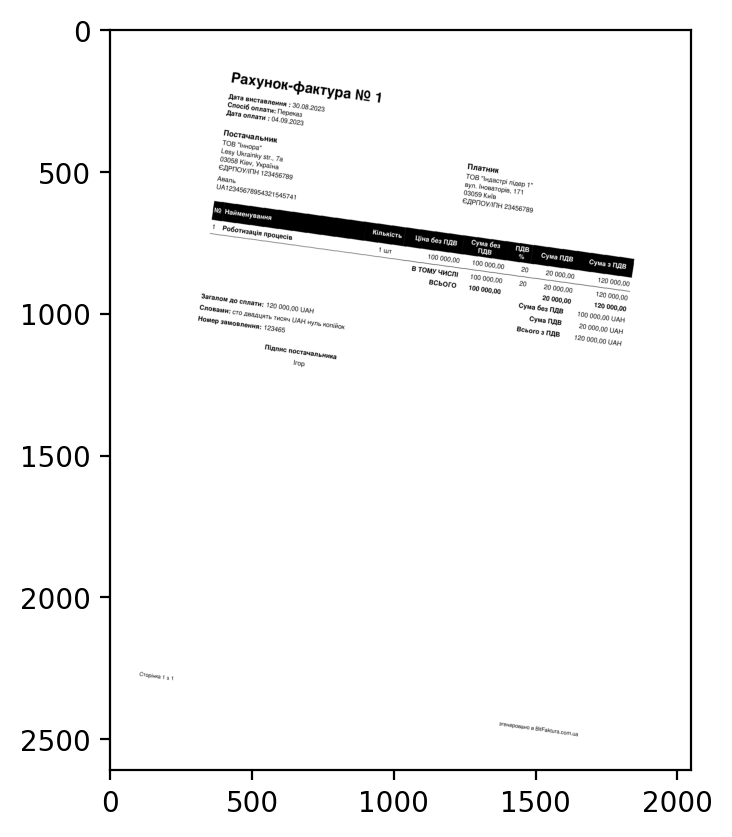

In [31]:
imge = Image.open('invoices_rotated/2.png')
imge = imge.rotate(-rt_angle, PIL.Image.NEAREST, expand = 1, fillcolor = 'white')
plt.imshow(imge)